## Upload de datos de relaciones y nodos al servidor de neo4j 

In [1]:
import json
import pandas as pd
from py2neo import Graph

from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

# Definir variables
uri = "bolt://10.33.1.189:4488"
user = "neo4j"
password = "Neo12345"

In [2]:
# Conexión a servidor local
graph = Graph(uri=uri, user=user, password=password)

In [3]:
qy_version="call dbms.components() yield name, versions, edition unwind versions as version return name, version, edition;"
print(graph.run(qy_version))

 name         | version | edition    
--------------|---------|------------
 Neo4j Kernel | 5.14.0  | enterprise 



In [9]:
def LoadData_Nodes(_graph, file_nodos, sep="';'"):
    """
    Carga los datos de nodos desde un archivo CSV en Neo4j.
 
    Inputs:
    _graph: Objeto de la conexión a la base de datos Neo4j utilizando la librería pyneo.
    file_nodos (str): Ruta al archivo CSV que contiene los datos de nodos.
    sep (str): Separador de campos en el archivo CSV.
 
    Output:
    elapsed_t (float): Tiempo transcurrido en segundos durante la carga de datos.
    """
    import time
    start_t = time.process_time()
 
    # Crea un índice único en el atributo CONT_RUT de los nodos de tipo Contribuyente
    _graph.run("CREATE CONSTRAINT FOR (p:Contribuyente) REQUIRE p.CONT_RUT IS UNIQUE;")
    _graph.run("call db.awaitIndexes();")
 
    print("Cargando archivos de nodos: %s ..." % (file_nodos))
    # Carga los nodos desde el archivo CSV especificado
    load_nodes = _graph.run("""
        LOAD CSV WITH HEADERS FROM '%s' AS row
        WITH row LIMIT 100
        CALL {
        WITH row
        CREATE (p:Contribuyente {
            cont_rut: row.cont_rut,
            score: coalesce(row.score, ''),
            total_pago_f29: coalesce(row.total_pago_f29, ''),
            IVA_neto: coalesce(row.IVA_neto, ''),
            unidad_regional: coalesce(row.unidad_regional, ''),
            n_documentos: coalesce(row.n_documentos, ''),
            lifetime: coalesce(row.lifetime, ''),
            alerta_inicial: coalesce(row.alerta_inicial, ''),
            comunidad: coalesce(row.comunidad, '')
            })
        RETURN row.cont_rut AS cont_rut
        } IN TRANSACTIONS OF 1000 rows
        RETURN *;
        """ % (file_nodos)).stats()
    print(load_nodes)
    elapsed_t = time.process_time() - start_t
    print("\nCarga de datos terminada en: %s " % (elapsed_t))
    return elapsed_t


In [10]:
LoadData_Nodes(graph, 'file:///contaminados_processed_iva_representante_total_with_labels_FILTERED.csv')

Cargando archivos de nodos: file:///contaminados_processed_iva_representante_total_with_labels_FILTERED.csv ...
{'labels_added': 36, 'nodes_created': 36, 'properties_set': 324}

Carga de datos terminada en: 0.005104600000000126 


0.005104600000000126

In [11]:
def LoadData_Arcs(graph, file_arcos, sep="';'"):
    """
    Carga los datos de arcos desde un archivo CSV en Neo4j.
 
    Inputs:
    _graph: Objeto de la conexión a la base de datos Neo4j utilizando la librería pyneo.
    file_arcos (str): Ruta al archivo CSV que contiene los datos de arcos.
    sep (str): Separador de campos en el archivo CSV.
 
    Output:
    elapsed_t (float): Tiempo transcurrido en segundos durante la carga de datos.
    """
    import time
    start_t = time.process_time()
 
    print("\nCargando archivo de relaciones: %s ..." % (file_arcos))
    # Carga los arcos desde el archivo CSV especificado
    load_rel = graph.run("""
    
        LOAD CSV WITH HEADERS FROM '%s' AS row
        CALL {
        WITH row
        MATCH (p1:Contribuyente {cont_rut:row.emisor})
        MATCH (p2:Contribuyente {cont_rut:row.receptor})
        MERGE (p1)-[rel:emite_a]->(p2) 
        SET
            rel.Fuerza = toFloat(row.Fi)
        RETURN count(rel) as count} IN TRANSACTIONS OF 1000 rows
        RETURN *;
        """ % (file_arcos)).stats()
    print(load_rel)
    elapsed_t = time.process_time() - start_t
    print("\nCarga de datos terminada en: %s " % (elapsed_t))
    return elapsed_t


In [12]:
LoadData_Arcs(graph, 'file:///fuerza_IVA_representante_FILTERED.csv')


Cargando archivo de relaciones: file:///fuerza_IVA_representante_FILTERED.csv ...
{'relationships_created': 34, 'properties_set': 34}

Carga de datos terminada en: 0.0029218999999995887 


0.0029218999999995887

In [5]:
query = """
MATCH (n) return count(n)
"""
graph.run(query)


count(n)
100


In [6]:
# Consulta Cypher para obtener las relaciones
query = """
MATCH (p1)-[rel]->(p2)
RETURN p1.cont_rut AS source, type(rel) AS relation, p2.cont_rut AS target
"""
graph.run(query)

source,relation,target
+7b292uop43C0rTcSHfOjA==,emite_a,+7b292uop43C0rTcSHfOjA==


In [6]:
def ClearDB(_graph, iter_max = 100, batch_size = 200000):
    #Remove nodes / links
    iter_n = 1
    deleted = 1    
    print("Borrando nodos...")
    print(["Iteracion", "Nodos eliminados"])
    while deleted > 0 and iter_n <= iter_max:
        deleted = _graph.run("""MATCH (n)
        WITH n LIMIT %s
        DETACH DELETE n
        RETURN count(*)"""%(batch_size)).evaluate()
        print([iter_n, deleted])
        iter_n += 1
    if deleted > 0:
        print("WARNING: Limite maximo de iteraciones alcanzado, no se han borrado todos los nodos/relaciones")
    # Drop constraints / indices
    for constraint in _graph.run("CALL db.constraints"):
        _graph.run("DROP " + constraint[0])
    return(_graph.run("CALL db.schema()").to_data_frame())

In [7]:
ClearDB(graph)

Borrando nodos...
['Iteracion', 'Nodos eliminados']
[1, 100]
[2, 0]


ClientError: [Procedure.ProcedureNotFound] There is no procedure with the name `db.constraints` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.

In [8]:
query = "DROP CONSTRAINT constraint_c3b81393"
graph.run(query)

(No data)

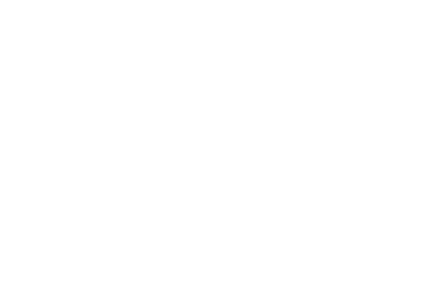

In [9]:
# Consulta Cypher para obtener las relaciones
query = """
MATCH (p1)-[rel]->(p2)
RETURN p1.cont_rut AS source, type(rel) AS relation, p2.cont_rut AS target
"""
result = graph.run(query)

# Crear un grafo dirigido desde el resultado de la consulta
G = nx.DiGraph()
for record in result:
    source = record["source"]
    relation = record["relation"]
    target = record["target"]
    G.add_edge(source, target, label=relation)

# Visualizar el grafo
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=50, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()

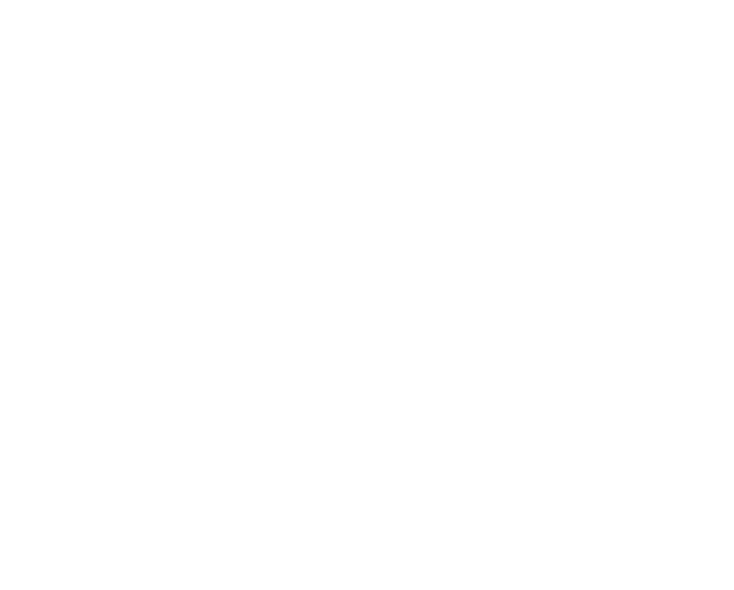

In [10]:
# Consulta Cypher para obtener las relaciones
query = """
MATCH (p1)-[rel]->(p2)
RETURN p1.cont_rut AS source, type(rel) AS relation, p2.cont_rut AS target
"""
result = graph.run(query)

# Crear un grafo dirigido desde el resultado de la consulta
G = nx.DiGraph()
for record in result:
    source = record["source"]
    relation = record["relation"]
    target = record["target"]
    G.add_edge(source, target, label=relation)

# Visualizar el grafo
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=50, node_color="lightblue", font_size=5, font_weight="bold")
plt.show()


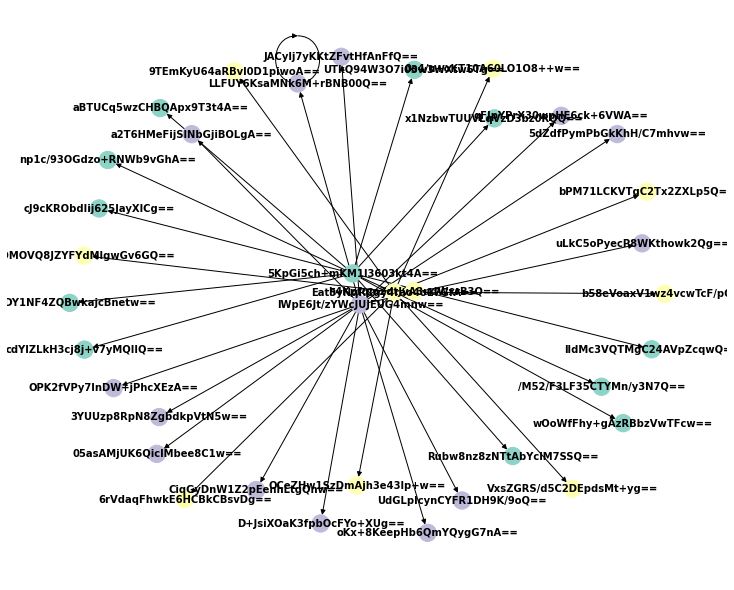

In [33]:
# Consulta Cypher para obtener las relaciones y comunidades
query = """
MATCH (p1)-[rel]->(p2)
RETURN p1.cont_rut AS source, type(rel) AS relation, p2.cont_rut AS target, p1.comunidad AS comunidad_source, p2.comunidad AS comunidad_target
"""
result = graph.run(query)

# Crear un grafo dirigido desde el resultado de la consulta
G = nx.DiGraph()
for record in result:
    source = record["source"]
    relation = record["relation"]
    target = record["target"]
    comunidad_source = record["comunidad_source"]
    comunidad_target = record["comunidad_target"]
    G.add_edge(source, target, label=relation)
    G.nodes[source]["comunidad"] = comunidad_source
    G.nodes[target]["comunidad"] = comunidad_target

# Crear una lista de colores únicos basados en las comunidades
unique_communities = list(set(nx.get_node_attributes(G, "comunidad").values()))
color_palette = plt.cm.Set3  # Paleta de colores
color_mapping = {community: color_palette(i) for i, community in enumerate(unique_communities)}

# Asignar colores a los nodos basados en las comunidades
node_colors = [color_mapping[G.nodes[node]["comunidad"]] for node in G.nodes()]

# Visualizar el grafo
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))  # Ajustar tamaño de la imagen según sea necesario
nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=300, node_color=node_colors, font_size=10, font_weight="bold")
plt.show()


In [34]:
# Consulta Cypher para obtener los distintos valores de la comunidad
query = """
MATCH (n)
RETURN DISTINCT n.comunidad AS comunidad
"""
result = graph.run(query)

# Obtener los valores únicos de la comunidad
unique_communities = [record["comunidad"] for record in result]

# Imprimir los valores únicos de la comunidad
print("Valores únicos de comunidad:")
for comunidad in unique_communities:
    print(comunidad)


Valores únicos de comunidad:
21552
18856
24949


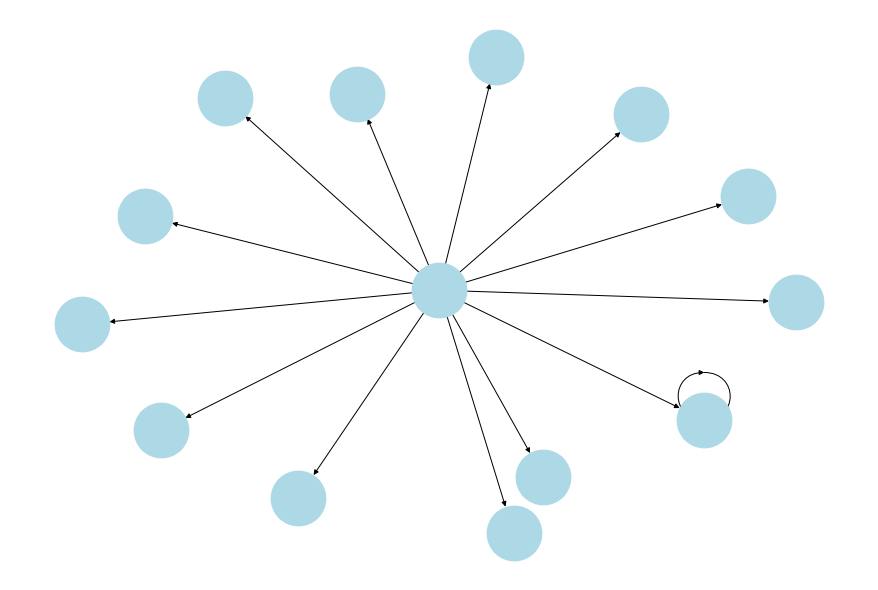

In [47]:
# Consulta Cypher para obtener las relaciones que involucran a los nodos con la comunidad 18856
query = """
MATCH (p1)-[rel]->(p2)
WHERE p1.comunidad = '18856' OR p2.comunidad = '18856'
RETURN p1.cont_rut AS source, p1.alerta_inicial AS alerta_inicial, p1.IVA_neto AS IVA_neto, type(rel) AS relation, p2.cont_rut AS target
"""
result = graph.run(query)

# Crear un grafo dirigido desde el resultado de la consulta
G = nx.DiGraph()
for record in result:
    source = record["source"]
    alerta_inicial = record["alerta_inicial"]
    IVA_total = record["IVA_neto"]
    relation = record["relation"]
    target = record["target"]
    G.add_edge(source, target, label=relation)

# Visualizar el grafo
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))  # Tamaño de la imagen
nx.draw(G, pos, with_labels=True, labels={node: f"{node}\nAlerta inicial: {alerta_inicial}\nIVA neto: {IVA_neto}" for node, alerta_inicial, IVA_total in zip(G.nodes(), nx.get_node_attributes(G, 'alerta_inicial').values(), nx.get_node_attributes(G, 'IVA_neto').values())}, node_size=3000, node_color="lightblue", font_size=5, font_weight="bold")
plt.show()
